## Aggregate the network with an optimization method

In [113]:
import sys
sys.path.append('../src')
import utils
import models as m

In [114]:
nodes_df, wind_df, solar_df = utils.import_data_county()
TimeSeries = {'wind': wind_df.iloc[:, 1:], 'solar': solar_df.iloc[:, 1:]};

In [115]:
network = utils.Network(nodes_df, TimeSeries)

The 'features' dictionary has been created and can be accessed as '.features'
It is a dictionary with keys for each node in range(0, 67).
Each value is a dictionary with the features of that node.

Example structure:
network.features[0].keys() = dict_keys(['position', 'time_series', 'duration_curves', 'ramp_duration_curves', 'correlation'])

Details:
  - Position: A tuple (latitude, longitude) of that node.
  - Time series: A dictionary with keys for each time series type in dict_keys(['wind', 'solar'])
    and values as the time series itself.
  - Duration Curves: A dictionary with keys for each time series type in dict_keys(['wind', 'solar'])
    and values as the duration curve of the time series.
  - Ramp Duration Curves (RDCs): A dictionary with keys for each time series type dict_keys(['wind', 'solar'])
    and values as the RDC (found by differentiating and subsequently sorting) of the time series.
  - Correlation: A dictionary with keys as tuples of types of time series
    and

In [116]:
node_features = network.features;

In [117]:
n_repr = 10
weights = {
                'position': 1.0,
                'time_series': 1.0,
                'duration_curves': 1.0,
                'rdc': 1.0,
                'correlation': 1.0
            }
aggregator = m.Aggregation(node_features, n_repr)

In [118]:
u_results, z_results = aggregator.optimize(weights)

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 4557 rows, 4556 columns and 13534 nonzeros
Model fingerprint: 0x9c3022af
Variable types: 0 continuous, 4556 integer (4556 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e-02, 5e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Presolve time: 0.03s
Presolved: 4557 rows, 4556 columns, 13534 nonzeros
Variable types: 0 continuous, 4556 integer (4556 binary)
Found heuristic solution: objective 41.0535153

Root relaxation: objective 3.107818e+01, 638 iterations, 0.03 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   31.07818 

In [119]:
visuals = utils.Visualization(network, u_results, n_repr, save_fig=True)

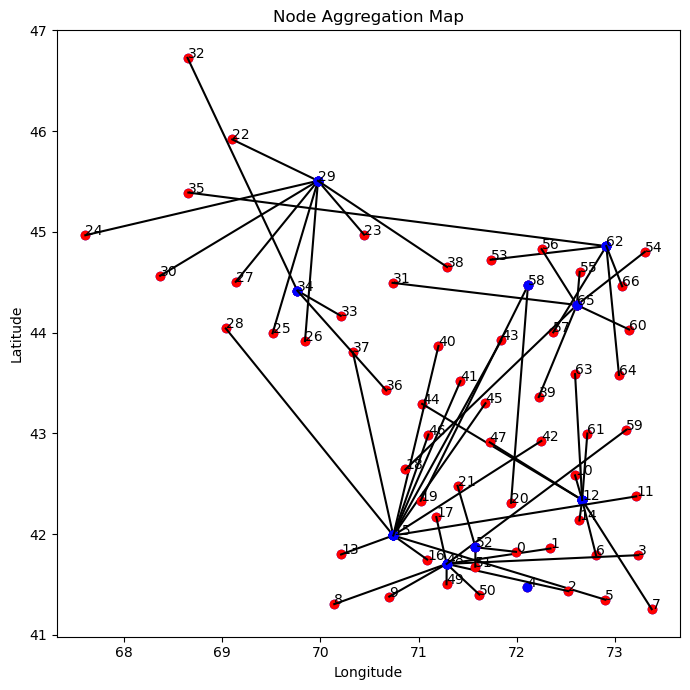

Figure saved as opti_agg_map_67_to_67.png at ../results/


In [120]:
visuals.plot_map()

Clusters:
Cluster 0: Nodes [18, 31, 39, 54, 56, 60, 65]
Cluster 1: Nodes [16]
Cluster 2: Nodes [22, 23, 24, 25, 26, 27, 29, 30, 38]
Cluster 3: Nodes [5, 11, 13, 15, 28, 35, 37, 40, 41, 42, 43, 45, 46, 53, 55, 62, 64, 66]
Cluster 4: Nodes [1, 2, 3, 8, 9, 17, 48, 49, 50]
Cluster 5: Nodes [19, 20, 58]
Cluster 6: Nodes [4]
Cluster 7: Nodes [6, 7, 10, 12, 14, 44, 47, 61, 63]
Cluster 8: Nodes [32, 33, 34, 36, 59]
Cluster 9: Nodes [0, 21, 51, 52, 57]

Cluster Centers:
[65, 16, 29, 43, 48, 58, 4, 12, 36, 52]


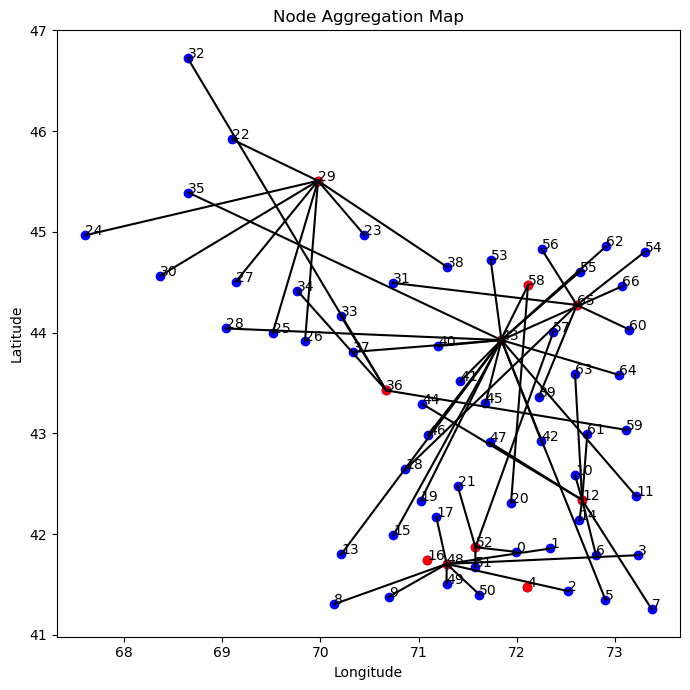

Figure saved as kmedoids_agg_map_67_to_10.png at ../results/


In [121]:
clusters_KMedoids, cluster_centers_KMedoids = aggregator.cluster_KMedoids(weights)

print("Clusters:")
for cluster_id, nodes in clusters_KMedoids.items():
    print(f"Cluster {cluster_id}: Nodes {nodes}")

print("\nCluster Centers:")
print(cluster_centers_KMedoids)

visuals.plot_map(method='kmedoids', kmedoids_medoids=cluster_centers_KMedoids, cluster_mapping=clusters_KMedoids)

In [122]:
original_features = node_features

aggregated_features_KMedoids = {}
for cluster_id, nodes in clusters_KMedoids.items():
    representative = cluster_centers_KMedoids[cluster_id]
    for node in nodes:
        aggregated_features_KMedoids[node] = node_features[representative]

aggregated_features_optimized = {}
for i, selected in enumerate(z_results):
    if selected:
        for j in range(len(u_results)):
            if u_results[j, i] == 1:
                aggregated_features_optimized[j] = node_features[i]

In [123]:
eval = m.AggregationMetrics(original_features)


Metrics for optimized aggregation:
{'REEav': 0.07043093576686914, 'NRMSEav': 0.016417892865025405, 'CEav': 0.03493645276118951, 'NRMSERDCav': 0.004269114711300549}

Metrics for KMedoids clustering:
{'REEav': 0.06913339190610553, 'NRMSEav': 0.01564214489033059, 'CEav': 0.03272252227464453, 'NRMSERDCav': 0.00445615257869907}


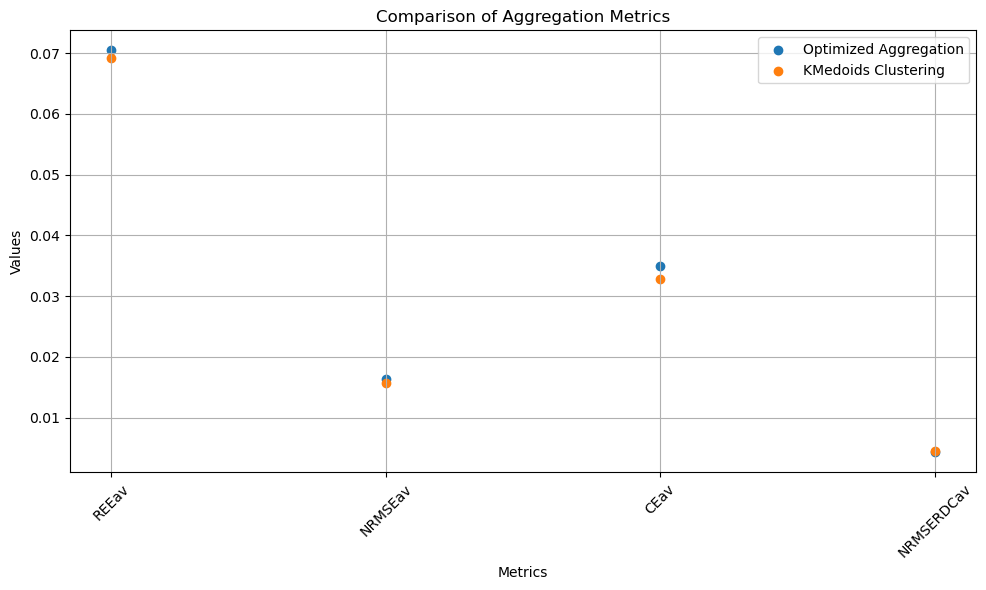

In [124]:
eval_metrics_optimized = eval.compute_metrics(aggregated_features_optimized)
eval_metrics_KMedoids = eval.compute_metrics(aggregated_features_KMedoids)

print("\nMetrics for optimized aggregation:")
print(eval_metrics_optimized)
print("\nMetrics for KMedoids clustering:")
print(eval_metrics_KMedoids)

metrics = list(eval_metrics_optimized.keys())
optimized_values = list(eval_metrics_optimized.values())
kmedoids_values = list(eval_metrics_KMedoids.values())

# Plotting
x = range(len(metrics))
plt.figure(figsize=(10, 6))
plt.scatter(x, optimized_values, label='Optimized Aggregation', marker='o')
plt.scatter(x, kmedoids_values, label='KMedoids Clustering', marker='o')
plt.xticks(x, metrics, rotation=45)
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Comparison of Aggregation Metrics')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
